# Calibrating resnet on CIFAR10 test set

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [3]:
import os
import sys
import time
import importlib
import collections
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.isotonic import IsotonicRegression


%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport utils.data
%aimport calibrators
from utils.ops import onehot_encode, optim_temperature, detection_log_likelihood_ratios
from utils.metrics import neg_log_likelihood, accuracy, empirical_cross_entropy
from utils.visualization import reliability_diagram, plot_nll_curve
from utils.data import get_cifar10, load_logits
from calibrators import PAVCalibrator, TempScalingCalibrator, MLRCalibrator, DummyCalibrator

In [4]:
%matplotlib inline

## Load CIFAR10 test-set

In [5]:
data_path = '../cifar-10'

In [6]:
cifar10, ix2label = get_cifar10(data_path, test=True)
print("Number of samples in the test set: {:d}".format(cifar10["test_labels"].shape[0]))

Number of samples in the test set: 10000


As part of the preprocessing, resnet models normalize to 1 and subtract the mean of the training set:

In [7]:
X_train = cifar10['images']/255.
train_mean = np.mean(X_train, axis=0)

X_test = cifar10['test_images']/255.- train_mean
y_test = onehot_encode(cifar10['test_labels'])

Check how classes are distributed:

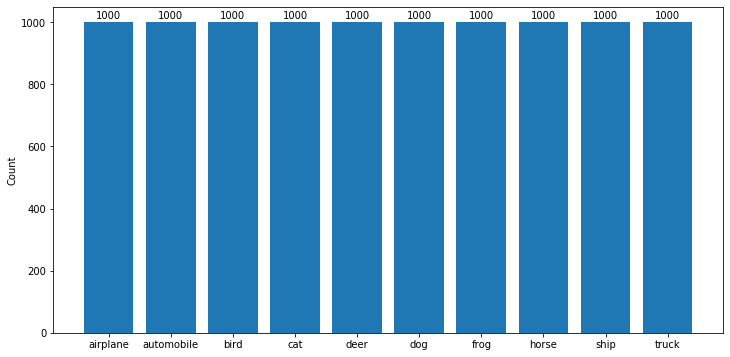

In [8]:
label_counter = collections.Counter(cifar10["test_labels"])

f, ax = plt.subplots(figsize=(12,6))
plt.bar(label_counter.keys(), label_counter.values(), tick_label=[ix2label[k] for k in label_counter.keys()]);
ax.set_ylabel('Count');

rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(height),
            ha='center', va='bottom')

## Load model

In [9]:
models_dir = '../pretrained-models'
model = 'resnet32_v1'

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

Visualize some predictions:

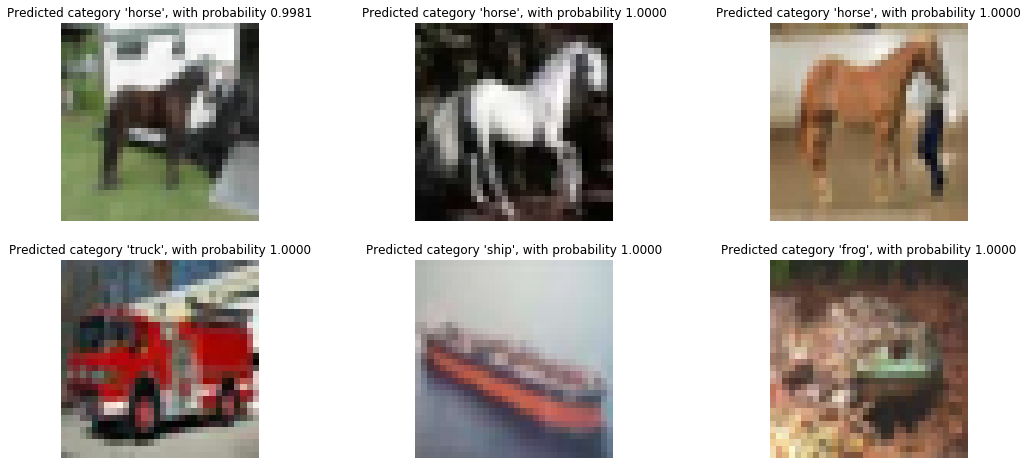

In [10]:
idxs = [20, 13, 543, 23, 999, 2304]

fig, ax_arr = plt.subplots(2, 3, figsize=(18, 8))


for i, idx in enumerate(idxs):
    test_ima = X_test[idx, :]
    pred = np.argmax(probs[idx, :])
    ax_arr[i//3, i%3].imshow(cifar10['test_images'][idx]/255.)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted category '{}', with probability {:.4f}".format(ix2label[pred], probs[idx, pred]))
    
plt.show();

### Compute NLL of the classifier on the test set 

In [11]:
un_cal = DummyCalibrator(logits, y_test)
probs = un_cal(logits)

base_nll = neg_log_likelihood(probs, y_test)
base_acc = accuracy(probs, y_test)

In [12]:
print("Negative log-likelihood of the classifier on the test set: {:.3f}".format(base_nll))
print("Accuracy of the classifier on the test set: {:.3f}".format(base_acc))

Negative log-likelihood of the classifier on the test set: 0.267
Accuracy of the classifier on the test set: 0.928


# Calibrating the network



## Temperature scaling calibration:

In [13]:
# Temp scaling
t0 = time.time()
temp_cal = TempScalingCalibrator(logits, y_test)
print("Optimal temperature found: {:.3f}, elapsed time: {:.3f}s".format(temp_cal.T, (time.time()-t0)))
temp_probs = temp_cal.predict(logits)

temp_nll = neg_log_likelihood(temp_probs, y_test)
temp_acc = accuracy(temp_probs, y_test)

print("Negative log-likelihood after calibration with temp-scaling: {:.3f}".format(temp_nll))
print("Accuracy after calibration with temp-scaling: {:.3f}".format(temp_acc))

Optimal temperature found: 1.745, elapsed time: 0.398s
Negative log-likelihood after calibration with temp-scaling: 0.221
Accuracy after calibration with temp-scaling: 0.928


Effect on the probabilities

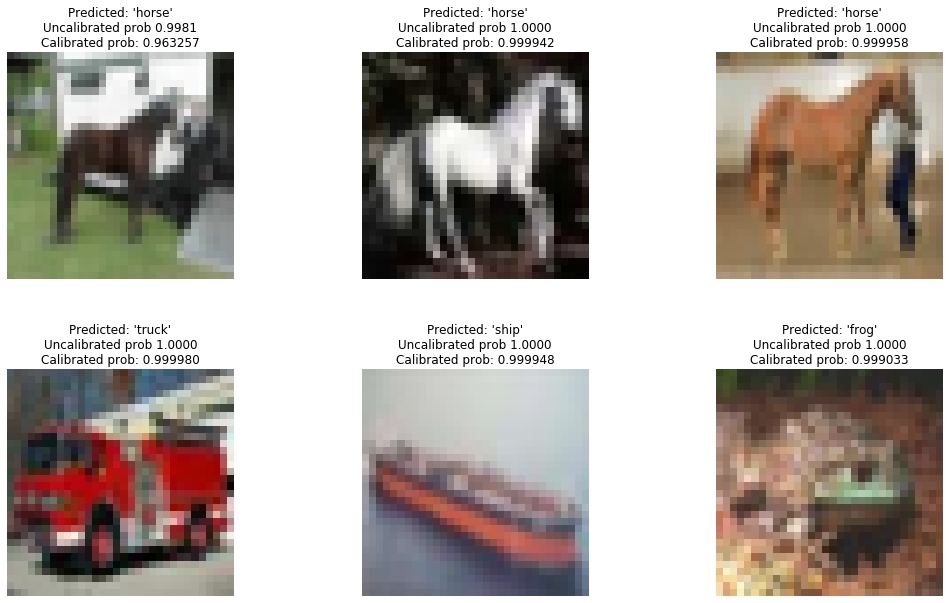

In [14]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], temp_probs[idx][pred]))
    
plt.show();

### Visualizing Calibration: 

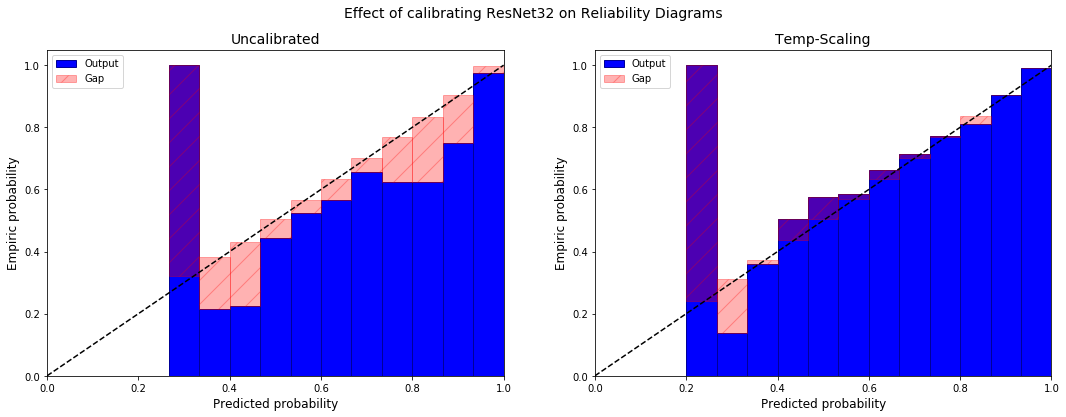

In [15]:
fig, ax_arr = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle("Effect of calibrating ResNet32 on Reliability Diagrams", fontsize=14)

ax_arr[0] = reliability_diagram(probs, y_test, ax=ax_arr[0], title='Uncalibrated')
ax_arr[1] = reliability_diagram(temp_probs, y_test, ax=ax_arr[1], title='Temp-Scaling')

plt.show()

## Calibrate with PAV extended to multiclass(normalization):

In [16]:
t0 = time.time()
pav_cal = PAVCalibrator(logits.astype(np.float), y_test.astype(np.float))
print("PAV calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

PAV calibration fitted, elapsed time: 0.188s


In [17]:
pav_probs = pav_cal.predict(logits.astype(np.float))

pav_nll = neg_log_likelihood(pav_probs, y_test)
pav_acc = accuracy(pav_probs, y_test)

print("Negative log-likelihood after calibration with PAV: {:.3f}".format(pav_nll))
print("Accuracy after calibration with PAV: {:.3f}".format(pav_acc))

Negative log-likelihood after calibration with PAV: 0.207
Accuracy after calibration with PAV: 0.929


Effect on probabilities:

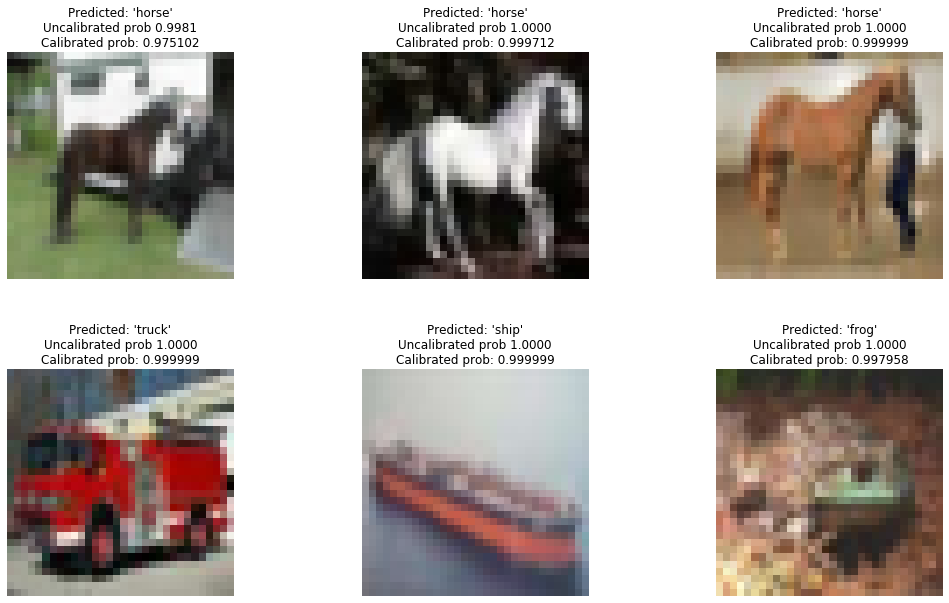

In [18]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], pav_probs[idx, pred]))
    
plt.show();

### Visualizing Calibration:

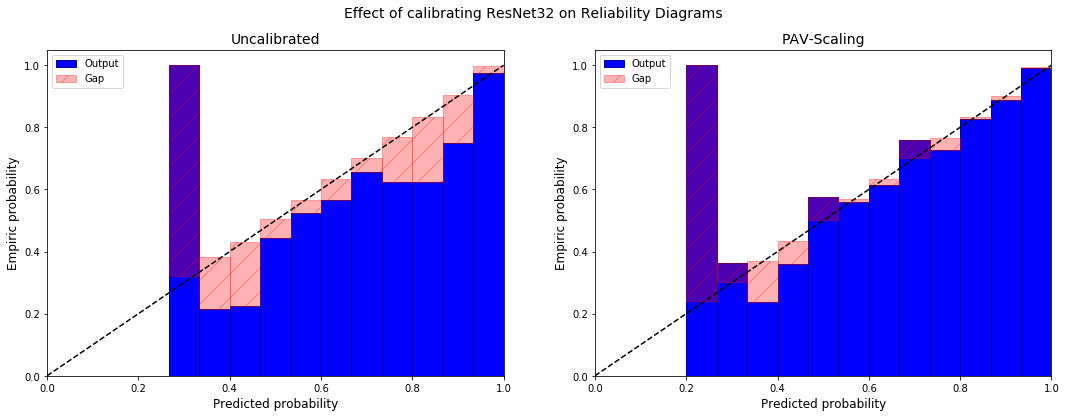

In [19]:
fig, ax_arr = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle("Effect of calibrating ResNet32 on Reliability Diagrams", fontsize=14)

ax_arr[0] = reliability_diagram(probs, y_test, ax=ax_arr[0], title='Uncalibrated')
ax_arr[1] = reliability_diagram(pav_probs, y_test, ax=ax_arr[1], title='PAV-Scaling')

plt.show()

## Calibrate using Multiclass Logistic Regression

In [20]:
t0 = time.time()
mlr_cal = MLRCalibrator(logits.astype(np.float), y_test.astype(np.float))
print("MLR calibration fitted, elapsed time: {:.3f}s".format(time.time()-t0))

MLR calibration fitted, elapsed time: 2.979s


In [21]:
mlr_probs = mlr_cal.predict(logits.astype(np.float))

mlr_nll = neg_log_likelihood(mlr_probs, y_test)
mlr_acc = accuracy(mlr_probs, y_test)

print("Negative log-likelihood after calibration with MLR: {:.3f}".format(mlr_nll))
print("Accuracy after calibration with MLR: {:.3f}".format(mlr_acc))

Negative log-likelihood after calibration with MLR: 0.219
Accuracy after calibration with MLR: 0.928


Effect on probabilities:

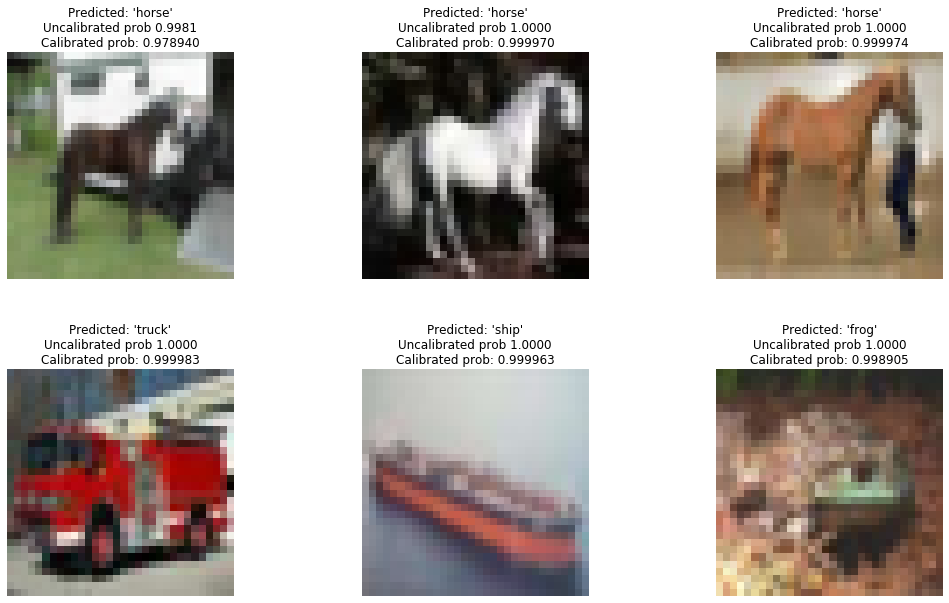

In [22]:
fig, ax_arr = plt.subplots(2, 3, figsize=(18, 10), gridspec_kw={'hspace': 0.4})


for i, idx in enumerate(idxs):
    test_ima = cifar10['test_images'][idx]/255.
    pred = np.argmax(probs[idx])
    ax_arr[i//3, i%3].imshow(test_ima)
    ax_arr[i//3, i%3].axis('off')
    ax_arr[i//3, i%3].set_title("Predicted: '{}'\nUncalibrated prob {:.4f}\nCalibrated prob: {:4f}".format(ix2label[pred], probs[idx][pred], mlr_probs[idx][pred]))
    
plt.show();

### Visualizing Calibration:

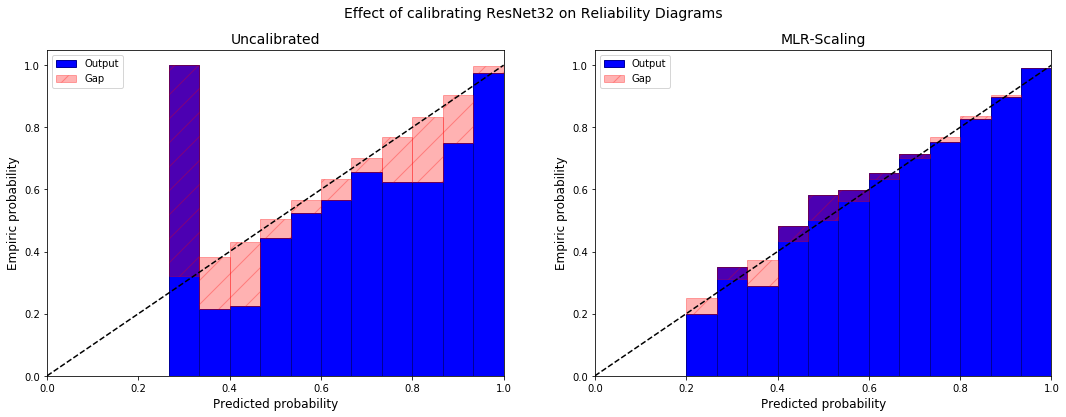

In [23]:
fig, ax_arr = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle("Effect of calibrating ResNet32 on Reliability Diagrams", fontsize=14)

ax_arr[0] = reliability_diagram(probs, y_test, ax=ax_arr[0], title='Uncalibrated')
ax_arr[1] = reliability_diagram(mlr_probs, y_test, ax=ax_arr[1], title='MLR-Scaling')

plt.show()

In [24]:
# fig.savefig('../../calibration.machine.learning/imgs/MLR_reliability_diagrams.png', dpi=300, bbox_inches='tight', pad_inches=0.4)

# Comparison of calibrators:

NLL curve:

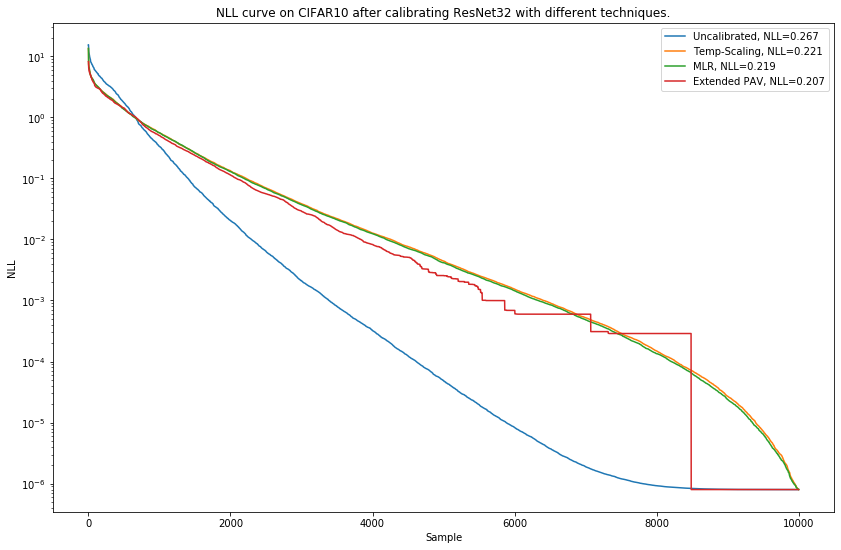

In [27]:
fig, ax = plt.subplots(figsize=(14, 9))

ax = plot_nll_curve(logits, 
                    y_test, 
                    [un_cal, temp_cal, mlr_cal, pav_cal], 
                    ax=ax,
                    labels=['Uncalibrated, NLL={:.3f}'.format(base_nll),
                            'Temp-Scaling, NLL={:.3f}'.format(temp_nll),
                            'MLR, NLL={:.3f}'.format(mlr_nll),
                            'Extended PAV, NLL={:.3f}'.format(pav_nll)],
                   title='NLL curve on CIFAR10 after calibrating ResNet32 with different techniques.')

plt.show()

In [28]:
fig.savefig('../../calibration.machine.learning/imgs/NLL_curve_example.png', dpi=300, bbox_inches='tight', pad_inches=0.4)